Created on Thu Apr 17, 2020
@uthor: Ruchilekha

Dataset used : https://github.com/UCSD-AI4H/COVID-CT
COVID-CT-Dataset: A CT Scan Dataset about COVID-19
Reference paper: Jinyu Zhao, Yichen Zhang, Xuehai He, Pengtao Xie: “COVID-CT-Dataset: A CT Scan Dataset about COVID-19” 
                 https://arxiv.org/pdf/2003.13865.pdf, 30 March 2020. 

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def find_accuracy(actual, predicted):
    print("accuracy=", accuracy_score (actual, predicted))
    print("precision, recall, fscore, support=",precision_recall_fscore_support(actual, predicted, average='macro'))

    
train_data_dir = "C://Users//DELL//Downloads//CT Scan Database"


# Directory with COVID CT ScanS
covid_dir = os.path.join(r"C://Users//DELL//Downloads//CT Scan Database//CT_COVID")

# Directory with Non-COVID CT Scans
noncovid_dir = os.path.join(r"C://Users//DELL//Downloads//CT Scan Database//CT_NonCOVID")

covid_names = os.listdir(covid_dir)
print(covid_names[:10])

noncovid_names = os.listdir(noncovid_dir)
print(noncovid_names[:10])

print('total COVID CT ScanS:', len(os.listdir(covid_dir)))
print('total Non-COVID CT Scans:', len(os.listdir(noncovid_dir)))


get_ipython().run_line_magic('matplotlib', 'inline')

['2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png', '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png', '2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png', '2020.01.24.919183-p27-132.png', '2020.01.24.919183-p27-133.png', '2020.01.24.919183-p27-134.png', '2020.01.24.919183-p27-135.png', '2020.02.10.20021584-p6-52%0.png', '2020.02.10.20021584-p6-52%1.png', '2020.02.10.20021584-p6-52%10.png']
['0.jpg', '1%0.jpg', '1%1.jpg', '1%2.jpg', '10%0.jpg', '10%1.jpg', '10%2.jpg', '102.png', '1029.png', '103.png']
total COVID CT ScanS: 358
total Non-COVID CT Scans: 397


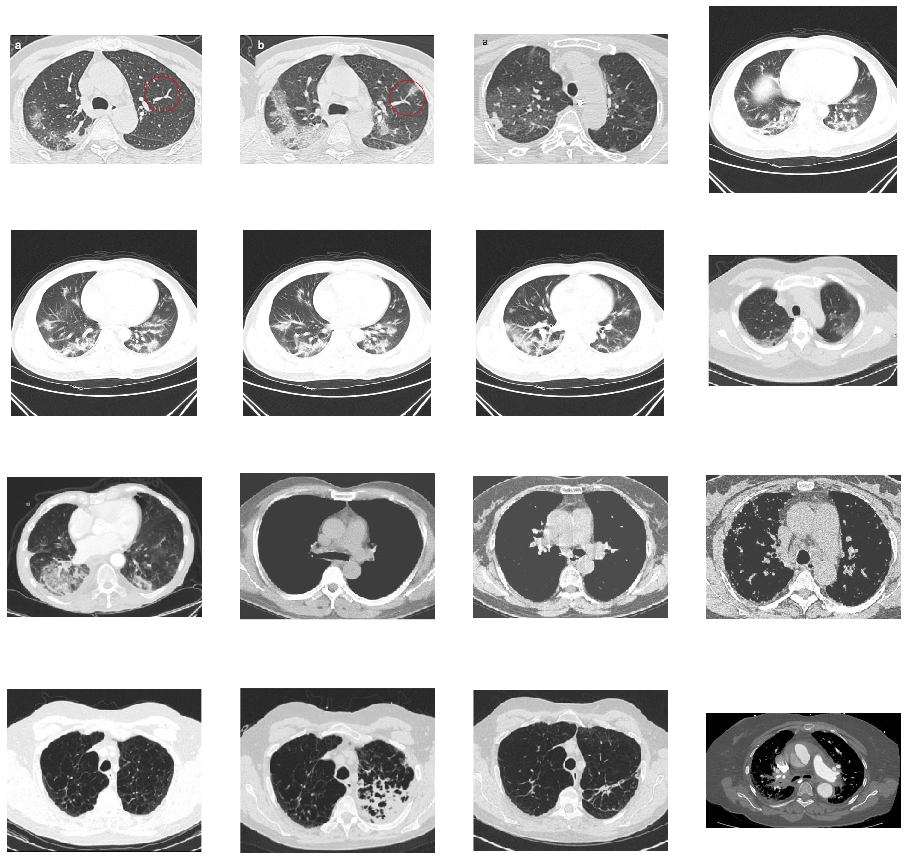

In [25]:
#DISPLAYING SOME PICTURES

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(covid_dir, fname) 
                for fname in covid_names[pic_index-8:pic_index]]
next_noncovid_pix = [os.path.join(noncovid_dir, fname) 
                for fname in noncovid_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_covid_pix+next_noncovid_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [26]:
#HYPER-PARAMETERS 
img_height = 224
img_width = 224
batch_size = 32
nb_epochs = 50
base_learning_rate = 0.0001

#DIVIDING THE IMAGES INTO TRAIN AND TEST

import glob
covid = glob.glob(covid_dir+"/*.*")
noncovid = glob.glob(noncovid_dir+"/*.*")


data = []
labels = []

for i in covid:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in noncovid:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(1)


data = np.array(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(755, 224, 224, 3)
(755,)


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

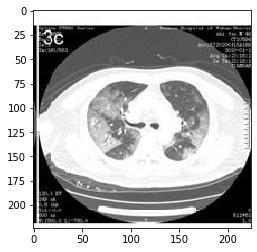

In [28]:
#DISPLAYING A PICTURE FROM TRAINING SET

plt.imshow(x_train[0])

In [29]:
#VGG16 MODEL

def vgg16():
    
    base_model = VGG16(input_shape=(img_height, img_width, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    
    
    base_model.trainable = False
    
    base_model.summary()
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      tf.keras.layers.Dense(1024,activation="relu"),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512,activation="relu"),
      tf.keras.layers.Dense(2,activation="softmax")
    ])

    return model

#Compiling 
model = vgg16()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

#model.load_weights('my_model_weights.h5')

clf = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=25)
#model.save_weights('my_model_weights.h5')
model.save('my_model_weights.h5')


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, model.predict(x_test))
print('AUC: %.2f' % auc)

AUC: 0.99


In [46]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, model.predict(x_test))
print('Accuracy: %.4f' % accuracy)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "d:\phd\lekha\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-1e28d6bbbb90>", line 2, in <module>
    accuracy = accuracy_score(y_test, model.predict(x_test))
  File "d:\phd\lekha\lib\site-packages\sklearn\metrics\classification.py", line 176, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\phd\lekha\lib\site-packages\sklearn\metrics\classification.py", line 81, in _check_targets
    "and {1} targets".format(type_true, type_pred))
ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\phd\lekha\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: '

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [42]:
def find_accuracy(actual, predicted):
    print("precision, recall, fscore, support=",precision_recall_fscore_support(actual, predicted, average='macro'))
print("accuracy=", accuracy_score (y_test, model.predict(x_test)))
print(find_accuracy(y_test, model.predict(x_test)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "d:\phd\lekha\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-d81b1b207cee>", line 3, in <module>
    print("accuracy=", accuracy_score (y_test, model.predict(x_test)))
  File "d:\phd\lekha\lib\site-packages\sklearn\metrics\classification.py", line 176, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "d:\phd\lekha\lib\site-packages\sklearn\metrics\classification.py", line 81, in _check_targets
    "and {1} targets".format(type_true, type_pred))
ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\phd\lekha\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
Attribu

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
#VGG16 ARCHITECTURE

from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, to_file='model_architecture.png')